In [ ]:
#importing required libraries

In [1]:
import os
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score


In [2]:
def load_images_from_folder(folder_path, label=None, img_size=(64, 64)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            img_flattened = img.flatten()  # Convert to 1D array
            images.append(img_flattened)
            if label is not None:
                labels.append(label)
    return images, labels


In [3]:
import cv2
from imutils.object_detection import non_max_suppression
import numpy as np
import imutils
## Histogram of Oriented Gradients Detector
HOGCV = cv2.HOGDescriptor()
HOGCV.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

In [4]:
import os
import numpy as np

# Base folder for suspicious activities
base_folder = "D:/new_activities"

# Suspicious classes
classes = {
    'normal':0, 'kick': 1, 'punch': 2, 'push': 3,
    'robbery': 4, 'shooting': 5, 'hit':6
}

activity_data = []
activity_labels = []

# Loop through each suspicious activity folder
for activity, label in classes.items():
    folder_path = os.path.join(base_folder, activity)  # Folder path for the current category
    if os.path.exists(folder_path):
        print(f"Loading data from: {folder_path}")
        data, labels = load_images_from_folder(folder_path, label=label)  # Load images and labels
        activity_data += data
        activity_labels += labels
    else:
        print(f"Folder not found: {folder_path}")

# Convert to NumPy arrays
X_activity = np.array(activity_data)
y_activity = np.array(activity_labels)

print(f"Total suspicious activity data loaded: {len(activity_data)}")

Loading data from: D:/new_activities\normal
Loading data from: D:/new_activities\kick
Loading data from: D:/new_activities\punch
Loading data from: D:/new_activities\push
Loading data from: D:/new_activities\robbery
Loading data from: D:/new_activities\shooting
Loading data from: D:/new_activities\hit
Total suspicious activity data loaded: 46551


In [5]:
# Activity classification split
X_train_act, X_test_act, y_train_act, y_test_act = train_test_split(
    X_activity, y_activity, test_size=0.2, random_state=42)

In [6]:
activity_rf = RandomForestClassifier(n_estimators=200, max_depth=30, random_state=42)
activity_rf.fit(X_train_act, y_train_act)
y_pred_act = activity_rf.predict(X_test_act)
y_pred_proba=activity_rf.predict_proba(X_test_act)[:, 1]
print("Activity Classification Accuracy:", accuracy_score(y_test_act, y_pred_act))
print(classification_report(y_test_act, y_pred_act))

Activity Classification Accuracy: 0.9865750187949737
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1098
           1       0.98      0.99      0.99      1058
           2       0.98      0.98      0.98      1727
           3       0.98      1.00      0.99      1911
           4       1.00      1.00      1.00       984
           5       1.00      1.00      1.00      1779
           6       0.99      0.97      0.98       754

    accuracy                           0.99      9311
   macro avg       0.99      0.98      0.99      9311
weighted avg       0.99      0.99      0.99      9311



In [7]:
import joblib
# Save activity classification model
activity_model_path = r"C:/Users/MSI/OneDrive/Desktop/image_project.pkl"
joblib.dump(activity_rf, activity_model_path)
print(f"Activity model saved to: {activity_model_path}")
import pickle
import numpy as np
from PIL import Image

Activity model saved to: C:/Users/MSI/OneDrive/Desktop/image_project.pkl


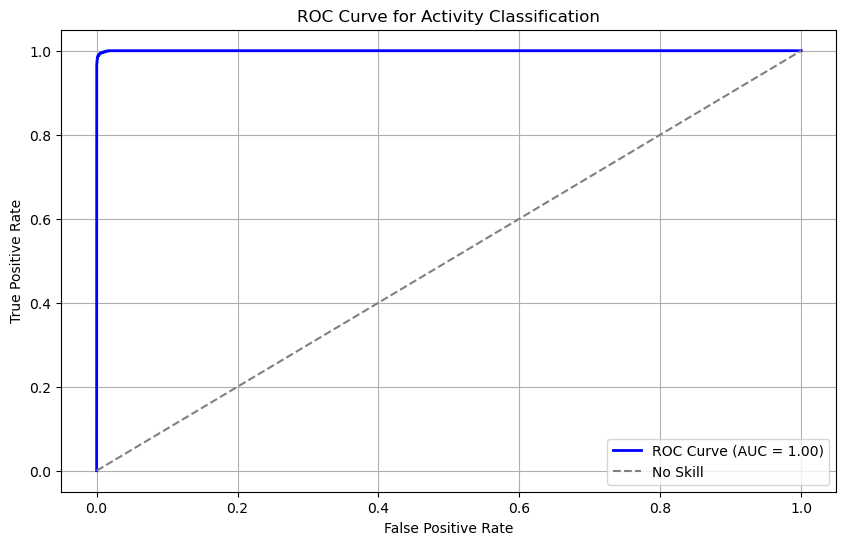

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_test_act and y_pred_proba are defined
fpr, tpr, _ = roc_curve(y_test_act, y_pred_proba, pos_label=1)  # Replace `pos_label` with the positive class label if needed
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='No Skill')  # Reference diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Activity Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

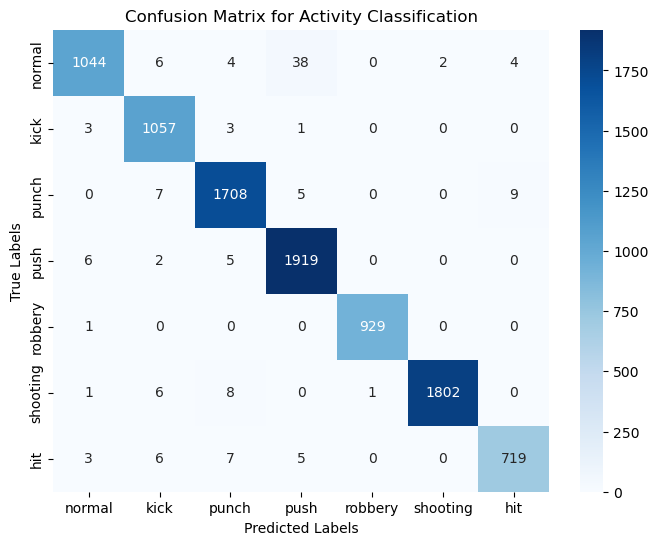

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
# Compute confusion matrix
cm = confusion_matrix(y_test_act, y_pred_act)

# Plot using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes.keys(), yticklabels=classes.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Activity Classification')
plt.show()


In [7]:
import gradio as gr
import cv2
import numpy as np
import joblib


In [8]:
# Load the pre-trained activity classification model
activity_model_path = r"C:/Users/MSI/OneDrive/Desktop/image_project.pkl"
activity_rf = joblib.load(activity_model_path)

In [9]:
# Define classes
classes = {
    'normal': 0, 'kick': 1, 'punch': 2, 'push': 3,
    'robbery': 4, 'shooting': 5, 'hit': 6
}

# Define Detector and preprocess_frame
HOGCV = cv2.HOGDescriptor()
HOGCV.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())


In [12]:
def Detector(frame):
    width = 900
    # Calculate aspect ratio to determine appropriate height
    aspect_ratio = frame.shape[1] / frame.shape[0]
    height = int(width / aspect_ratio)
    #frame=imutils.resize(frame,width=800)
    
    # Resize with calculated width and height
    frame = cv2.resize(frame, (width, height))
    #frame=imutils.resize(frame,width=900)
    rects, weights = HOGCV.detectMultiScale(frame, winStride=(8, 8), padding=(8, 8), scale=1.08)
    rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
    pick = non_max_suppression(rects, probs=None, overlapThresh=0.7)
    pedestrian_detected = len(pick) > 0
    return pedestrian_detected, len(pick)
    
    

def preprocess_frame(frame, img_size=(64, 64)):
    frame_resized = cv2.resize(frame, img_size)
    frame_normalised=frame_resized/255.0
    return frame_normalised.flatten().reshape(1, -1)

def classify_frame(image):
    frame = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert to BGR as OpenCV uses BGR format
    pedestrian_present, pedestrian_count = Detector(frame)
    
        
    if pedestrian_present:
        activity_label_idx = activity_rf.predict(preprocess_frame(frame))[0]
        activity_label = list(classes.keys())[list(classes.values()).index(activity_label_idx)]
        return f"Pedestrian Detected", f"Activity: {activity_label}"
        
    return "No Pedestrian Detected", ""

def process_image(image):
    status, activity = classify_frame(image)
    return status, activity

# Gradio Interface
def gradio_interface(image):
    status, activity = process_image(image)
    return status, activity
#theme=gr.themes.Soft()
interface = gr.Interface(
    fn=gradio_interface,
    inputs=gr.Image(type="numpy", label="Upload Image"),
   outputs=[
        gr.Textbox(label="Detection Status"),
        gr.Textbox(label="Activity Detected")
    ],
    title="Pedestrian and Activity Detection",
    description="Upload an image to detect pedestrians and classify their activity.",
    #theme=theme
)

interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7863
* Running on public URL: https://cbc379db61bab07318.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
